# Rerouting

The goal of this notebook is to show how to find new shortest paths after a filtered subgraph has been constructed.

In [1]:
import Pkg

pkgs = [
    "MetaGraphs",
    "Graphs",
    "Plots",
    "GraphRecipes",
    "Statistics"
]

for pkg in pkgs
    try
        eval(Meta.parse("import $pkg"))
    catch
        Pkg.add(pkg)
        eval(Meta.parse("import $pkg"))
    end
end

In [56]:
function create_distance_matrix(g)
    distance_matrix = fill(Inf, Graphs.nv(g), Graphs.nv(g))
    for edge in Graphs.edges(g)
        total_weight = g.vprops[edge.src][:weight] + g.vprops[edge.dst][:weight]
        mean_weight = total_weight / 2
        inverse_weight = 1 / mean_weight
        distance_matrix[edge.src, edge.dst] = distance_matrix[edge.dst, edge.src] = inverse_weight
    end
    distance_matrix
end

create_distance_matrix (generic function with 1 method)

Here, we define a section of graph with parallel paths, where one path has twice the nodeweight of the other

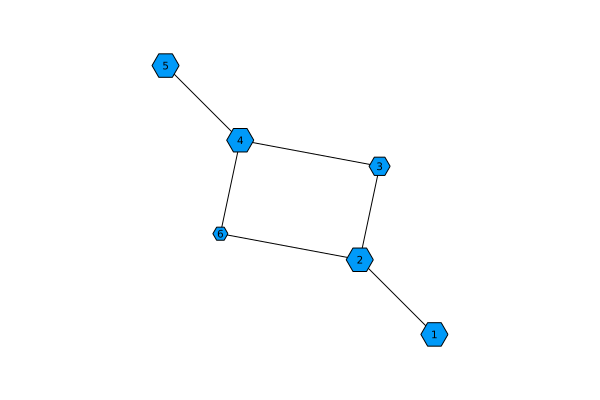

In [53]:
g = MetaGraphs.MetaGraph(Graphs.SimpleGraph(6))
vertex_weights = [
    1 => 3,
    2 => 3,
    3 => 2,
    4 => 3,
    5 => 3,
    6 => 1
]
for (vertex, weight) in vertex_weights
    MetaGraphs.set_prop!(g, vertex, :weight, weight)
end

# primary path
Graphs.add_edge!(g, 1, 2); 
Graphs.add_edge!(g, 2, 3)
Graphs.add_edge!(g, 3, 4)
Graphs.add_edge!(g, 4, 5)

# alternate path
Graphs.add_edge!(g, 2, 6)
Graphs.add_edge!(g, 6, 4)

GraphRecipes.graphplot(
    g,
    curves=false,
    names=collect(Graphs.vertices(g)),
    node_weights=map(v -> g.vprops[v][:weight], Graphs.vertices(g)),
    nodesize=1/5
)

By default, we have a path that goes through the lowest frequency node, 6

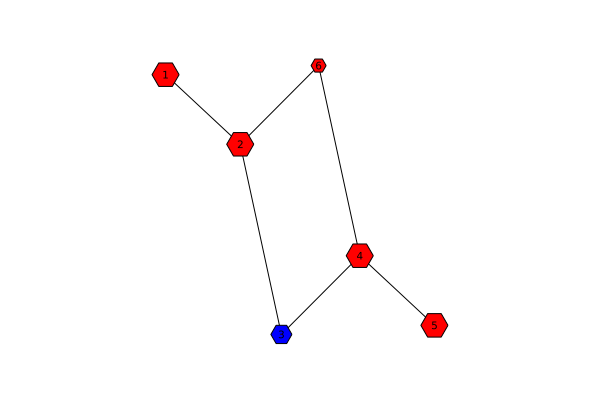

In [57]:
path = [1, 2, 6, 4, 5]
markercolor = [v in path ? :red : :blue for v in Graphs.vertices(g)]

GraphRecipes.graphplot(
    g,
    curves=false,
    names=collect(Graphs.vertices(g)),
    node_weights=map(v -> g.vprops[v][:weight], Graphs.vertices(g)),
    nodesize=1/5,
    markercolor = markercolor
)

Now, let's say that we want to re-route around node 6

Here we define a distance matrix where `distance = 1 / mean(weight_v1, weight_v2)`

This enables use to maximize relative likelihood by minimizing distance such that shortest path algorithms will now find the maximum likelihood paths.

To force-rerouting around 6, we'll set the distance from all nodes to 6 to infinity

In [58]:
distance_matrix = create_distance_matrix(g)
distance_matrix[6, :] .= Inf
distance_matrix[:, 6] .= Inf
distance_matrix

6×6 Matrix{Float64}:
 Inf         0.333333  Inf   Inf        Inf        Inf
  0.333333  Inf         0.4  Inf        Inf        Inf
 Inf         0.4       Inf    0.4       Inf        Inf
 Inf        Inf         0.4  Inf         0.333333  Inf
 Inf        Inf        Inf    0.333333  Inf        Inf
 Inf        Inf        Inf   Inf        Inf        Inf

  0.000189 seconds (256 allocations: 27.531 KiB)


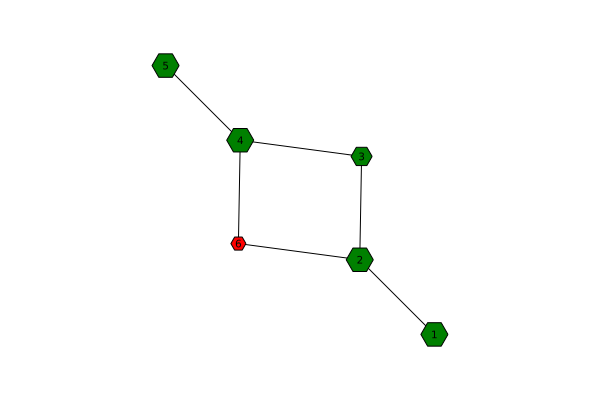

In [59]:
source = 1
target = 5

yen_k = Graphs.yen_k_shortest_paths(g, source, target, distance_matrix, 2)
alt_path = yen_k.paths[1]

markercolor = [v in alt_path ? :green : markercolor[v] for v in Graphs.vertices(g)]

GraphRecipes.graphplot(
    g,
    curves=false,
    names=collect(Graphs.vertices(g)),
    node_weights=map(v -> g.vprops[v][:weight], Graphs.vertices(g)),
    nodesize=1/5,
    markercolor = markercolor
)